# LLM-Based Content Analysis

This notebook implements an LLM-based content analysis system using Ollama and llama3.2-3b to evaluate RSS feed content quality and intent.

## Goals

1. **Connect to Ollama** - Set up connection to local Ollama server
2. **Design Analysis Prompt** - Create structured prompts for content evaluation
3. **Implement Scoring System** - Score content from 1-100 based on multiple criteria
4. **Content Token Management** - Limit content to max 2000 tokens for processing
5. **Analyze RSS Data** - Process collected RSS feed data through LLM
6. **Compare Results** - Compare with previous filtering approaches

## Analysis Criteria

The LLM will evaluate content based on:
- **Promotional/Ad Content Detection** - Identify marketing material vs news
- **Information Value** - Assess meaningful information content
- **News Quality** - Evaluate news value and relevance
- **Impact Assessment** - Determine potential impact and importance
- **Overall Quality Score** - Composite score from 1-100

## Configuration
- **Model**: llama3.2-3b
- **Server**: 192.168.2.13:11434 (default Ollama port)
- **Temperature**: 1.0
- **Seed**: 42
- **Max Tokens**: 2000 per content piece


## Setup and Imports


In [1]:
import json
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from typing import List, Dict, Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# Progress tracking
from tqdm.auto import tqdm

# Token counting (approximate)
import re

print("✅ All imports loaded successfully")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ All imports loaded successfully
📅 Analysis date: 2025-09-22 22:53:20


## Ollama Connection and Configuration


In [2]:
# Ollama configuration
OLLAMA_HOST = "192.168.2.13"
OLLAMA_PORT = "11434"
OLLAMA_MODEL = "llama3.2:3b"
OLLAMA_URL = f"http://{OLLAMA_HOST}:{OLLAMA_PORT}"

# Analysis parameters
TEMPERATURE = 1.0
SEED = 42
MAX_TOKENS = 2000

print(f"🔗 Ollama Configuration:")
print(f"   Host: {OLLAMA_HOST}:{OLLAMA_PORT}")
print(f"   Model: {OLLAMA_MODEL}")
print(f"   Temperature: {TEMPERATURE}")
print(f"   Seed: {SEED}")
print(f"   Max Tokens: {MAX_TOKENS}")

# Test connection
def test_ollama_connection():
    """Test if Ollama server is accessible"""
    try:
        response = requests.get(f"{OLLAMA_URL}/api/tags", timeout=10)
        if response.status_code == 200:
            models = response.json().get('models', [])
            print(f"✅ Ollama connection successful")
            print(f"📋 Available models: {[m['name'] for m in models]}")
            return True
        else:
            print(f"❌ Ollama connection failed: {response.status_code}")
            return False
    except Exception as e:
        print(f"❌ Ollama connection error: {e}")
        return False

# Test connection
test_ollama_connection()


🔗 Ollama Configuration:
   Host: 192.168.2.13:11434
   Model: llama3.2:3b
   Temperature: 1.0
   Seed: 42
   Max Tokens: 2000
✅ Ollama connection successful
📋 Available models: ['llama3.2:3b', 'deepseek-r1:7b', 'llama3.1:latest', 'qwen3:4b', 'llama3.2:latest', 'llama3:latest']


True

## Content Analysis System


In [3]:
class LLMContentAnalyzer:
    """LLM-based content analysis system using Ollama"""
    
    def __init__(self, host, port, model, temperature=1.0, seed=42):
        self.url = f"http://{host}:{port}"
        self.model = model
        self.temperature = temperature
        self.seed = seed
        
    def estimate_tokens(self, text):
        """Rough token estimation (4 chars per token average)"""
        return len(text) // 4
    
    def truncate_content(self, text, max_tokens=2000):
        """Truncate content to fit within token limit"""
        if self.estimate_tokens(text) <= max_tokens:
            return text
        
        # Truncate to approximately max_tokens
        max_chars = max_tokens * 4
        truncated = text[:max_chars]
        
        # Try to end at a sentence boundary
        last_period = truncated.rfind('.')
        if last_period > max_chars * 0.8:  # If period is in last 20%
            truncated = truncated[:last_period + 1]
            
        return truncated + " [Content truncated...]"
    
    def create_analysis_prompt(self, title, content, summary=""):
        """Create structured prompt for content analysis"""
        prompt = f"""You are an expert content analyst for a tech newsletter. Analyze the following article and provide a structured assessment.

TITLE: {title}
SUMMARY: {summary}
CONTENT: {content}

Please analyze this content and provide scores from 1-100 for each criterion. Respond ONLY with a JSON object in this exact format:

{{
    "is_promotional": <true/false>,
    "promotional_score": <1-100>,
    "information_value": <1-100>,
    "news_quality": <1-100>,
    "impact_score": <1-100>,
    "overall_quality": <1-100>,
    "reasoning": "<brief explanation of your assessment>"
}}

SCORING GUIDELINES:
- promotional_score: 1-30 = not promotional, 31-70 = somewhat promotional, 71-100 = highly promotional/ads
- information_value: 1-30 = low value, 31-70 = moderate value, 71-100 = high informational value
- news_quality: 1-30 = not news/relevant, 31-70 = somewhat newsworthy, 71-100 = highly newsworthy
- impact_score: 1-30 = low impact, 31-70 = moderate impact, 71-100 = high impact/important
- overall_quality: Weighted combination considering all factors

Focus on tech relevance, information density, and news value. Be strict with promotional content."""

        return prompt
    
    def analyze_content(self, title, content, summary="", max_retries=3):
        """Analyze content using LLM"""
        # Prepare content
        content_to_analyze = self.truncate_content(content, MAX_TOKENS)
        
        # Create prompt
        prompt = self.create_analysis_prompt(title, content_to_analyze, summary)
        
        # Prepare request payload
        payload = {
            "model": self.model,
            "prompt": prompt,
            "stream": False,
            "options": {
                "temperature": self.temperature,
                "seed": self.seed
            }
        }
        
        # Make request with retries
        for attempt in range(max_retries):
            try:
                response = requests.post(
                    f"{self.url}/api/generate",
                    json=payload,
                    timeout=120  # 2 minutes timeout
                )
                
                if response.status_code == 200:
                    result = response.json()
                    response_text = result.get('response', '')
                    
                    # Try to extract JSON from response
                    try:
                        # Look for JSON in the response
                        json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
                        if json_match:
                            analysis = json.loads(json_match.group())
                            return {
                                'success': True,
                                'analysis': analysis,
                                'raw_response': response_text,
                                'tokens_used': self.estimate_tokens(content_to_analyze)
                            }
                        else:
                            raise ValueError("No JSON found in response")
                            
                    except (json.JSONDecodeError, ValueError) as e:
                        if attempt < max_retries - 1:
                            print(f"⚠️ JSON parsing failed (attempt {attempt + 1}): {e}")
                            time.sleep(2)  # Wait before retry
                            continue
                        else:
                            return {
                                'success': False,
                                'error': f"JSON parsing failed: {e}",
                                'raw_response': response_text,
                                'tokens_used': self.estimate_tokens(content_to_analyze)
                            }
                else:
                    if attempt < max_retries - 1:
                        print(f"⚠️ HTTP error {response.status_code} (attempt {attempt + 1})")
                        time.sleep(2)
                        continue
                    else:
                        return {
                            'success': False,
                            'error': f"HTTP {response.status_code}: {response.text}",
                            'tokens_used': self.estimate_tokens(content_to_analyze)
                        }
                        
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"⚠️ Request failed (attempt {attempt + 1}): {e}")
                    time.sleep(2)
                    continue
                else:
                    return {
                        'success': False,
                        'error': str(e),
                        'tokens_used': self.estimate_tokens(content_to_analyze)
                    }
        
        return {
            'success': False,
            'error': 'Max retries exceeded',
            'tokens_used': self.estimate_tokens(content_to_analyze)
        }

# Initialize analyzer
analyzer = LLMContentAnalyzer(OLLAMA_HOST, OLLAMA_PORT, OLLAMA_MODEL, TEMPERATURE, SEED)
print("🤖 LLM Content Analyzer initialized")


🤖 LLM Content Analyzer initialized


## Load and Prepare RSS Data


In [4]:
# Load RSS data
print("📂 Loading RSS data...")
with open('../data/rss/rss_data.json', 'r', encoding='utf-8') as f:
    rss_data = json.load(f)

articles = rss_data['articles']
metadata = rss_data['metadata']

print(f"✅ Loaded {len(articles)} articles from {metadata['feeds_processed']} feeds")

# Convert to DataFrame
df = pd.DataFrame(articles)

# Clean and prepare data
df['title'] = df['title'].fillna('')
df['content'] = df['content'].fillna('')
df['summary'] = df['summary'].fillna('')

# Remove articles with very short content
df = df[df['content'].str.len() > 100]

print(f"📝 Prepared {len(df)} articles for LLM analysis")
print(f"📏 Content length stats:")
print(f"   Min: {df['content'].str.len().min()} chars")
print(f"   Max: {df['content'].str.len().max()} chars")
print(f"   Mean: {df['content'].str.len().mean():.0f} chars")


📂 Loading RSS data...
✅ Loaded 491 articles from 77 feeds
📝 Prepared 158 articles for LLM analysis
📏 Content length stats:
   Min: 101 chars
   Max: 22229 chars
   Mean: 3261 chars


## Test LLM Analysis on Sample Articles


In [5]:
# Test on a few sample articles first
print("🧪 Testing LLM analysis on sample articles...")

# Select diverse sample articles
sample_indices = [0, 10, 20, 30, 40]  # Take every 10th article for variety
sample_articles = df.iloc[sample_indices].copy()

results = []
for idx, row in tqdm(sample_articles.iterrows(), total=len(sample_articles), desc="Analyzing samples"):
    print(f"\n📰 Analyzing: {row['title'][:60]}...")
    
    result = analyzer.analyze_content(
        title=row['title'],
        content=row['content'],
        summary=row['summary']
    )
    
    if result['success']:
        print(f"✅ Success - Overall Quality: {result['analysis'].get('overall_quality', 'N/A')}")
        results.append({
            'index': idx,
            'title': row['title'],
            'feed_name': row['feed_name'],
            'success': True,
            'analysis': result['analysis'],
            'tokens_used': result['tokens_used']
        })
    else:
        print(f"❌ Failed: {result['error']}")
        results.append({
            'index': idx,
            'title': row['title'],
            'feed_name': row['feed_name'],
            'success': False,
            'error': result['error'],
            'tokens_used': result.get('tokens_used', 0)
        })

print(f"\n📊 Sample Analysis Results:")
print(f"   Successful: {sum(1 for r in results if r['success'])}/{len(results)}")
print(f"   Failed: {sum(1 for r in results if not r['success'])}/{len(results)}")

# Show successful analyses
print("\n🏆 Sample Analysis Details:")
for result in results:
    if result['success']:
        analysis = result['analysis']
        print(f"\n📰 {result['title'][:50]}...")
        print(f"   Source: {result['feed_name']}")
        print(f"   Overall Quality: {analysis.get('overall_quality', 'N/A')}/100")
        print(f"   Information Value: {analysis.get('information_value', 'N/A')}/100")
        print(f"   News Quality: {analysis.get('news_quality', 'N/A')}/100")
        print(f"   Promotional: {analysis.get('is_promotional', 'N/A')} (Score: {analysis.get('promotional_score', 'N/A')}/100)")
        print(f"   Impact: {analysis.get('impact_score', 'N/A')}/100")
        print(f"   Reasoning: {analysis.get('reasoning', 'N/A')[:100]}...")
    else:
        print(f"\n❌ {result['title'][:50]}... - {result['error']}")


🧪 Testing LLM analysis on sample articles...


Analyzing samples:   0%|          | 0/5 [00:00<?, ?it/s]


📰 Analyzing: Facebook Dating tries using AI to end ‘swipe fatigue’...
✅ Success - Overall Quality: 65

📰 Analyzing: Three crashes in the first day? Tesla’s robotaxi test in Aus...
✅ Success - Overall Quality: 72

📰 Analyzing: Gizmodo Science Fair: A Stem Cell Treatment for Severely Dam...
✅ Success - Overall Quality: 65

📰 Analyzing: Target announced dates for its fall Target Circle Week. Duh,...
✅ Success - Overall Quality: 55

📰 Analyzing: How to navigate cuffing season as a single person...
✅ Success - Overall Quality: 68

📊 Sample Analysis Results:
   Successful: 5/5
   Failed: 0/5

🏆 Sample Analysis Details:

📰 Facebook Dating tries using AI to end ‘swipe fatig...
   Source: The Verge
   Overall Quality: 65/100
   Information Value: 60/100
   News Quality: 70/100
   Promotional: False (Score: 0/100)
   Impact: 80/100
   Reasoning: The article is written in a neutral tone and provides specific details about Facebook's new AI featu...

📰 Three crashes in the first day? Tesla’s robo

## Batch Analysis (Optional - Process More Articles)


In [6]:
# Process all articles
# WARNING: This will take a very long time (several hours) and use significant resources

print("🚀 Starting full batch analysis...")
print(f"📊 Processing {len(df)} articles")
print("⏰ Estimated time: 2-5 minutes per article")

batch_results = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Full batch analysis"):
    result = analyzer.analyze_content(
        title=row['title'],
        content=row['content'],
        summary=row['summary']
    )
    
    batch_results.append({
        'index': idx,
        'title': row['title'],
        'feed_name': row['feed_name'],
        'feed_category': row.get('feed_category', ''),
        'url': row.get('url', ''),
        'published': row.get('published', ''),
        'success': result['success'],
        'analysis': result.get('analysis', {}),
        'error': result.get('error', ''),
        'tokens_used': result.get('tokens_used', 0)
    })

# Filter successful results
successful_results = [r for r in batch_results if r['success']]
print(f"✅ Full batch analysis complete: {len(successful_results)}/{len(batch_results)} successful")



🚀 Starting full batch analysis...
📊 Processing 158 articles
⏰ Estimated time: 2-5 minutes per article


Full batch analysis:   0%|          | 0/158 [00:00<?, ?it/s]

⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 2): Expecting value: line 8 column 18 (char 180)
⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 2): No JSON found in response
⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 2): No JSON found in response
⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 2): No JSON found in response
⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 1): No JSON found in response
⚠️ JSON parsing failed (attempt 2): No JSON found in response
⚠️ JSON parsing failed (attempt 1): No JSON found i

## Analysis and Visualization


📊 Full Batch Analysis Statistics:
   Overall Quality: 66.7 ± 12.1
   Information Value: 62.3 ± 12.6
   News Quality: 66.2 ± 15.7
   Impact Score: 64.5 ± 16.6
   Promotional Score: 26.6 ± 38.2
   Promotional Articles: 47/152 (30.9%)


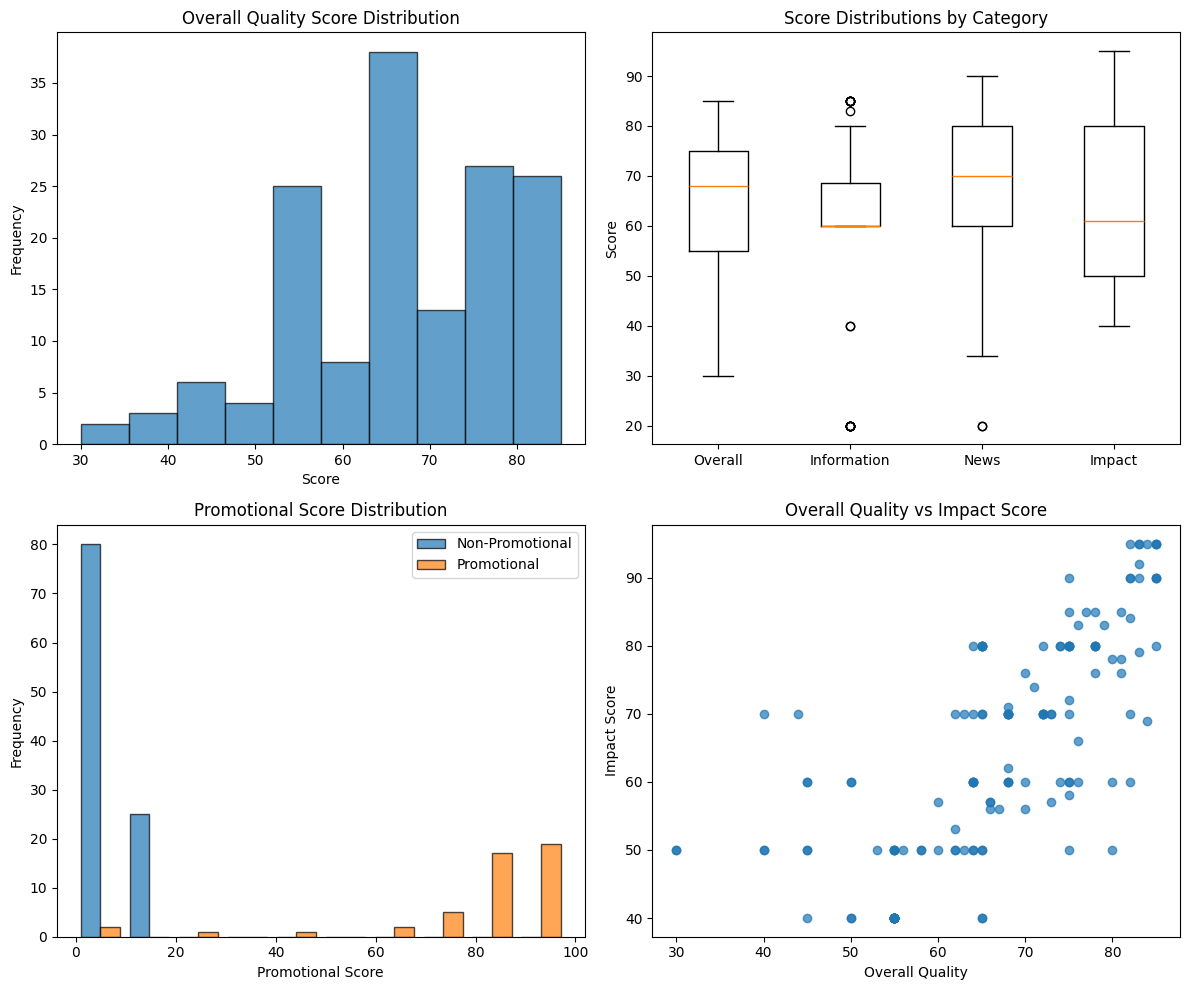


🏆 Top 5 Articles by Overall Quality:
1. Nvidia is partnering up with OpenAI to offer compute and cas...
   Quality: 85/100
   Source: The Verge
   Reasoning: The article reports on a strategic partnership between OpenAI and Nvidia, provid...
2. Gizmodo Science Fair: A Rocket Engine That Turns Controlled ...
   Quality: 85/100
   Source: Gizmodo
   Reasoning: The article is well-written and conveys complex technical information in a clear...
3. Alibaba Qwen Team Just Released FP8 Builds of Qwen3-Next-80B...
   Quality: 85/100
   Source: MarkTechPost (AI News)
   Reasoning: The article is informative about Alibaba's Qwen team releasing FP8 builds of the...
4. MIT Researchers Enhanced Artificial Intelligence (AI) 64x Be...
   Quality: 85/100
   Source: MarkTechPost (AI News)
   Reasoning: The article presents original research by MIT CSAIL researchers on enhancing art...
5. Google is testing out a whole new vibe for voice search in i...
   Quality: 85/100
   Source: Android Authority
   

In [7]:
# Analyze batch results (use full batch if available, otherwise sample results)
if 'batch_results' in locals() and batch_results:
    results_to_analyze = batch_results
    analysis_type = "Full Batch"
elif results:
    results_to_analyze = results
    analysis_type = "Sample"
else:
    results_to_analyze = []
    analysis_type = "None"

if results_to_analyze:
    successful_results = [r for r in results_to_analyze if r['success']]
    
    if successful_results:
        print(f"📊 {analysis_type} Analysis Statistics:")
        
        # Extract scores
        overall_scores = [r['analysis'].get('overall_quality', 0) for r in successful_results]
        info_scores = [r['analysis'].get('information_value', 0) for r in successful_results]
        news_scores = [r['analysis'].get('news_quality', 0) for r in successful_results]
        impact_scores = [r['analysis'].get('impact_score', 0) for r in successful_results]
        promo_scores = [r['analysis'].get('promotional_score', 0) for r in successful_results]
        
        print(f"   Overall Quality: {np.mean(overall_scores):.1f} ± {np.std(overall_scores):.1f}")
        print(f"   Information Value: {np.mean(info_scores):.1f} ± {np.std(info_scores):.1f}")
        print(f"   News Quality: {np.mean(news_scores):.1f} ± {np.std(news_scores):.1f}")
        print(f"   Impact Score: {np.mean(impact_scores):.1f} ± {np.std(impact_scores):.1f}")
        print(f"   Promotional Score: {np.mean(promo_scores):.1f} ± {np.std(promo_scores):.1f}")
        
        # Count promotional content
        promotional_count = sum(1 for r in successful_results if r['analysis'].get('is_promotional', False))
        print(f"   Promotional Articles: {promotional_count}/{len(successful_results)} ({promotional_count/len(successful_results)*100:.1f}%)")
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Overall quality distribution
        axes[0, 0].hist(overall_scores, bins=10, alpha=0.7, edgecolor='black')
        axes[0, 0].set_title('Overall Quality Score Distribution')
        axes[0, 0].set_xlabel('Score')
        axes[0, 0].set_ylabel('Frequency')
        
        # Score comparison
        score_data = [overall_scores, info_scores, news_scores, impact_scores]
        score_labels = ['Overall', 'Information', 'News', 'Impact']
        axes[0, 1].boxplot(score_data, labels=score_labels)
        axes[0, 1].set_title('Score Distributions by Category')
        axes[0, 1].set_ylabel('Score')
        
        # Promotional vs non-promotional
        promo_scores_promo = [r['analysis'].get('promotional_score', 0) for r in successful_results if r['analysis'].get('is_promotional', False)]
        promo_scores_non = [r['analysis'].get('promotional_score', 0) for r in successful_results if not r['analysis'].get('is_promotional', False)]
        
        axes[1, 0].hist([promo_scores_non, promo_scores_promo], bins=10, alpha=0.7, 
                       label=['Non-Promotional', 'Promotional'], edgecolor='black')
        axes[1, 0].set_title('Promotional Score Distribution')
        axes[1, 0].set_xlabel('Promotional Score')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        
        # Quality vs Impact scatter
        axes[1, 1].scatter(overall_scores, impact_scores, alpha=0.7)
        axes[1, 1].set_title('Overall Quality vs Impact Score')
        axes[1, 1].set_xlabel('Overall Quality')
        axes[1, 1].set_ylabel('Impact Score')
        
        plt.tight_layout()
        plt.show()
        
        # Show top and bottom articles
        print("\n🏆 Top 5 Articles by Overall Quality:")
        top_articles = sorted(successful_results, key=lambda x: x['analysis'].get('overall_quality', 0), reverse=True)[:5]
        for i, article in enumerate(top_articles, 1):
            print(f"{i}. {article['title'][:60]}...")
            print(f"   Quality: {article['analysis'].get('overall_quality', 0)}/100")
            print(f"   Source: {article['feed_name']}")
            print(f"   Reasoning: {article['analysis'].get('reasoning', 'N/A')[:80]}...")
        
        print("\n📉 Bottom 5 Articles by Overall Quality:")
        bottom_articles = sorted(successful_results, key=lambda x: x['analysis'].get('overall_quality', 0))[:5]
        for i, article in enumerate(bottom_articles, 1):
            print(f"{i}. {article['title'][:60]}...")
            print(f"   Quality: {article['analysis'].get('overall_quality', 0)}/100")
            print(f"   Source: {article['feed_name']}")
            print(f"   Reasoning: {article['analysis'].get('reasoning', 'N/A')[:80]}...")
    
    else:
        print("❌ No successful analyses to display")
else:
    print("❌ No results to analyze")


## Save Results


In [8]:
# Save results for further analysis
if 'batch_results' in locals() and batch_results:
    # Save full batch results
    output_data = {
        'metadata': {
            'timestamp': datetime.now().isoformat(),
            'model_used': OLLAMA_MODEL,
            'temperature': TEMPERATURE,
            'seed': SEED,
            'max_tokens': MAX_TOKENS,
            'ollama_host': f"{OLLAMA_HOST}:{OLLAMA_PORT}",
            'analysis_type': 'full_batch',
            'total_articles_processed': len(batch_results),
            'successful_analyses': len([r for r in batch_results if r['success']]),
            'failed_analyses': len([r for r in batch_results if not r['success']])
        },
        'full_batch_analyses': batch_results
    }
    output_file = '../data/llm_analysis/llm_full_batch_analysis_results.json'
elif results:
    # Save sample results
    output_data = {
        'metadata': {
            'timestamp': datetime.now().isoformat(),
            'model_used': OLLAMA_MODEL,
            'temperature': TEMPERATURE,
            'seed': SEED,
            'max_tokens': MAX_TOKENS,
            'ollama_host': f"{OLLAMA_HOST}:{OLLAMA_PORT}",
            'analysis_type': 'sample',
            'total_articles_processed': len(results),
            'successful_analyses': len([r for r in results if r['success']]),
            'failed_analyses': len([r for r in results if not r['success']])
        },
        'sample_analyses': results
    }
    output_file = '../data/llm_analysis/llm_sample_analysis_results.json'
else:
    output_data = None
    output_file = None

if output_data:
    # Save to file
    import os
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Results saved to {output_file}")
    
    # Also save a summary
    if successful_results:
        summary_stats = {
            'total_analyzed': len(successful_results),
            'avg_overall_quality': float(np.mean([r['analysis'].get('overall_quality', 0) for r in successful_results])),
            'avg_information_value': float(np.mean([r['analysis'].get('information_value', 0) for r in successful_results])),
            'avg_news_quality': float(np.mean([r['analysis'].get('news_quality', 0) for r in successful_results])),
            'avg_impact_score': float(np.mean([r['analysis'].get('impact_score', 0) for r in successful_results])),
            'avg_promotional_score': float(np.mean([r['analysis'].get('promotional_score', 0) for r in successful_results])),
            'promotional_articles': len([r for r in successful_results if r['analysis'].get('is_promotional', False)]),
            'high_quality_articles': len([r for r in successful_results if r['analysis'].get('overall_quality', 0) > 70]),
            'low_quality_articles': len([r for r in successful_results if r['analysis'].get('overall_quality', 0) < 40])
        }
        
        summary_file = '../data/llm_analysis/llm_analysis_summary.json'
        with open(summary_file, 'w', encoding='utf-8') as f:
            json.dump(summary_stats, f, indent=2, ensure_ascii=False)
        
        print(f"✅ Summary saved to {summary_file}")
        print(f"📊 Summary Statistics:")
        for key, value in summary_stats.items():
            print(f"   {key}: {value}")
else:
    print("❌ No results to save")


✅ Results saved to ../data/llm_analysis/llm_full_batch_analysis_results.json
✅ Summary saved to ../data/llm_analysis/llm_analysis_summary.json
📊 Summary Statistics:
   total_analyzed: 152
   avg_overall_quality: 66.6842105263158
   avg_information_value: 62.28947368421053
   avg_news_quality: 66.23684210526316
   avg_impact_score: 64.48026315789474
   avg_promotional_score: 26.625
   promotional_articles: 47
   high_quality_articles: 63
   low_quality_articles: 2
